In [28]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

import cv2

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os, numpy as np, shutil, random
from os.path import join

In [2]:
IMAGE_SHAPE = (300, 300)

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
data_dir

228818944/228813984 [==============================] - 2s 0us/step


'./datasets/flower_photos'

In [4]:
!ls ./datasets/flower_photos

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [5]:
!rm ./datasets/flower_photos/LICENSE.txt

In [6]:
!ls ./datasets/flower_photos

daisy  dandelion  roses  sunflowers  tulips


In [7]:
classes = os.listdir(data_dir)
classes

['daisy', 'roses', 'tulips', 'dandelion', 'sunflowers']

In [8]:
# # Creating Train / Val / Test folders (One time use)
def create_train_val_test(root_data_dir, output_dir, val_ratio=0, test_ratio=0):
  # class labels
  class_labels = os.listdir(root_data_dir)

  # creating folders
  try:
    for cls in class_labels:
      os.makedirs(join(output_dir, 'train', cls))
      os.makedirs(join(output_dir, 'val', cls))
      os.makedirs(join(output_dir, 'test', cls))
  except:
    pass

  for cls in class_labels:
    src = join(root_data_dir, cls)
    
    all_files = os.listdir(src)
    np.random.shuffle(all_files)

    train_names = all_files

    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(all_files), [
                                                              int(len(all_files) * (1 - (val_ratio + test_ratio))),
                                                              int(len(all_files) * (1 - test_ratio)),
                                                              ])
    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(join(src, name), join(output_dir, 'train', cls, name))
    for name in val_FileNames:
        shutil.copy(join(src, name), join(output_dir, 'val', cls, name))
    for name in test_FileNames:
        shutil.copy(join(src, name), join(output_dir, 'test', cls, name))


In [9]:
# shutil.rmtree(join(data_dir, 'train'))
# shutil.rmtree(join(data_dir, 'val'))
# shutil.rmtree(join(data_dir, 'test'))

In [10]:
create_train_val_test(data_dir, data_dir, val_ratio=0.1, test_ratio=0)

In [11]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_data = train_gen.flow_from_directory(join(data_dir, 'train'), target_size=IMAGE_SHAPE)
val_data = val_gen.flow_from_directory(join(data_dir, 'val'), target_size=IMAGE_SHAPE)

Found 3301 images belonging to 5 classes.
Found 369 images belonging to 5 classes.


In [17]:
val_data

In [21]:
model_1 = tf.keras.Sequential([
                               hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1", trainable=False),
                               tf.keras.layers.Dense(5, activation='softmax')
                               ])
model_1.build([None, *IMAGE_SHAPE, 3])

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1536)              10783528  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 7685      
Total params: 10,791,213
Trainable params: 7,685
Non-trainable params: 10,783,528
_________________________________________________________________


In [22]:
history_1 = model_1.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=val_data, validation_steps=len(val_data))

Epoch 1/5
104/104 [==============================] - 38s 241ms/step - loss: 0.6187 - accuracy: 0.7992 - val_loss: 0.3182 - val_accuracy: 0.9079
Epoch 2/5
104/104 [==============================] - 24s 228ms/step - loss: 0.2739 - accuracy: 0.9203 - val_loss: 0.2423 - val_accuracy: 0.9350
Epoch 3/5
104/104 [==============================] - 24s 226ms/step - loss: 0.2084 - accuracy: 0.9421 - val_loss: 0.2127 - val_accuracy: 0.9350
Epoch 4/5
104/104 [==============================] - 23s 225ms/step - loss: 0.1708 - accuracy: 0.9537 - val_loss: 0.1858 - val_accuracy: 0.9512
Epoch 5/5
104/104 [==============================] - 24s 226ms/step - loss: 0.1454 - accuracy: 0.9643 - val_loss: 0.1761 - val_accuracy: 0.9485


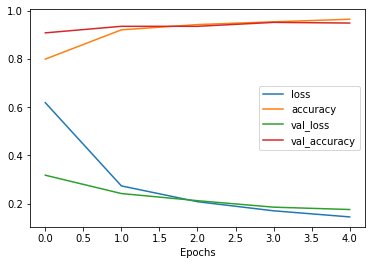

In [23]:
import pandas as pd
pd.DataFrame(history_1.history).plot(xlabel='Epochs')

In [34]:
classes = [k for k, v in train_data.class_indices.items()]
classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [63]:
def plot_pred_image(class_name=None, file_name=None, custom_file=None):
  if custom_file:
    img = cv2.cvtColor(cv2.imread(custom_file), cv2.COLOR_BGR2RGB)
  else:
    if not class_name:
      class_name = classes[random.randint(0, len(classes)-1)]
    if not file_name:
      all_file = os.listdir(os.path.join(data_dir, class_name))
      file_name = all_file[random.randint(0, len(all_file)-1)]
    img = cv2.cvtColor(cv2.imread(os.path.join(data_dir, class_name, file_name)), cv2.COLOR_BGR2RGB)
  
  pred = model_1.predict(tf.expand_dims(cv2.resize(img, IMAGE_SHAPE), axis=0) / 255)
  pred = pred.squeeze()
  class_int = np.argmax(pred)
  plt.imshow(img)
  plt.title(f'{round(pred[class_int]*100, 2)}% {classes[class_int]} ({class_name})')
  plt.axis(False)

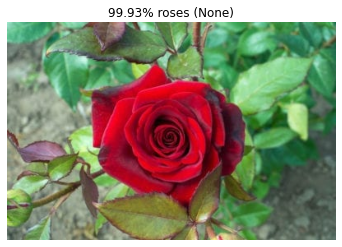

In [65]:
!wget -q https://www.gardeningknowhow.com/wp-content/uploads/2019/11/red-rose-400x265.jpg
plot_pred_image(custom_file='red-rose-400x265.jpg')

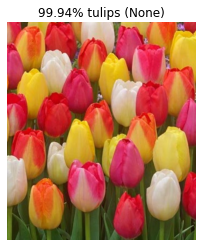

In [66]:
!wget -q https://cdn.webshopapp.com/shops/108044/files/55293608/650x750x1/tulipa-tulip-festival.jpg
plot_pred_image(custom_file='tulipa-tulip-festival.jpg')

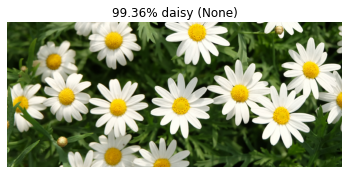

In [67]:
!wget -q https://www.proflowers.com/blog/wp-content/uploads/2020/09/april-birth-flower-daisy-hero.jpg
plot_pred_image(custom_file='april-birth-flower-daisy-hero.jpg')

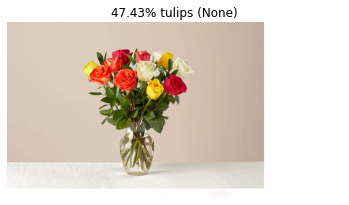

In [68]:
!wget -q https://cdn.shopify.com/s/files/1/0507/3754/5401/t/1/assets/F492_LOL_preset_ftd-hero-lv-new.jpeg
plot_pred_image(custom_file='F492_LOL_preset_ftd-hero-lv-new.jpeg')

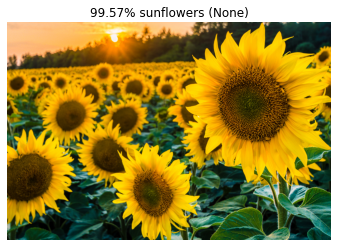

In [70]:
!wget -q https://hosstools.com/wp-content/uploads/2020/10/black-oil-sunflower.jpg
plot_pred_image(custom_file='black-oil-sunflower.jpg')